In [21]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [22]:

# Caminho para o arquivo CSV e diretório de imagens
metadata_csv_path = os.path.join('ISIC-images/ISIC-images', 'metadata.csv')
image_folder = 'ISIC-images/ISIC-images'

# Carregar o metadata.csv
metadata_df = pd.read_csv(metadata_csv_path)

# Filtrar para classes benignas e malignas apenas
metadata_df = metadata_df[metadata_df['benign_malignant'].isin(['benign', 'malignant'])]



In [23]:
# Mapear classes para rótulos binários
metadata_df['label'] = metadata_df['benign_malignant'].map({'benign': 0, 'malignant': 1})

# Função para carregar e pré-processar imagens
def load_and_preprocess_images(image_ids, image_folder, target_size=(64, 64)):
    images = []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, f'{image_id}.JPG')
        try:
            image = Image.open(image_path).convert('L')  # Converter para escala de cinza
            image = image.resize(target_size)
            image = np.array(image).flatten()  # Achatar a imagem
            images.append(image)
        except FileNotFoundError:
            print(f'Image {image_path} not found. Skipping.')
    return np.array(images)

# Carregar imagens
image_ids = metadata_df['isic_id'].tolist()
X = load_and_preprocess_images(image_ids, image_folder)


In [24]:
# Remover entradas com imagens ausentes
valid_indices = [i for i, x in enumerate(X) if x is not None]
X = np.array([X[i] for i in valid_indices])
y = metadata_df['label'].values[valid_indices]

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar os recursos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Treinar um modelo Perceptron Multicamadas
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = mlp.predict(X_test)

In [26]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Calcular especificidade para cada classe
specificity_per_class = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)


In [27]:
# Média das especificidades
mean_specificity = sum(specificity_per_class) / len(specificity_per_class)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Sensibilidade: {recall}")
print(f"Especificidade: {mean_specificity}")

Acurácia: 0.839690436705362
Precisão: 0.8235933652640052
Sensibilidade: 0.839690436705362
Especificidade: 0.6282031479847013


Acurácia: 0.839690436705362
Relatório de Classificação:
               precision    recall  f1-score   support

      benign       0.89      0.93      0.91      1545
   malignant       0.43      0.33      0.38       264

    accuracy                           0.84      1809
   macro avg       0.66      0.63      0.64      1809
weighted avg       0.82      0.84      0.83      1809

Matriz de Confusão:
 [[1432  113]
 [ 177   87]]


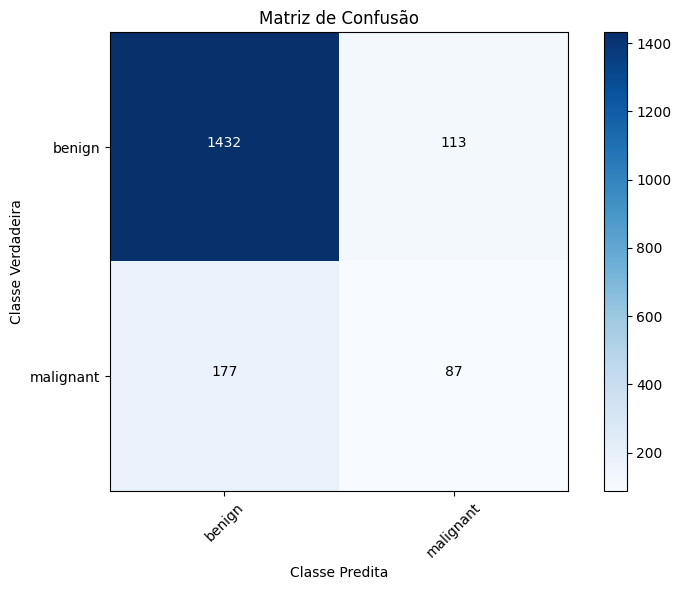

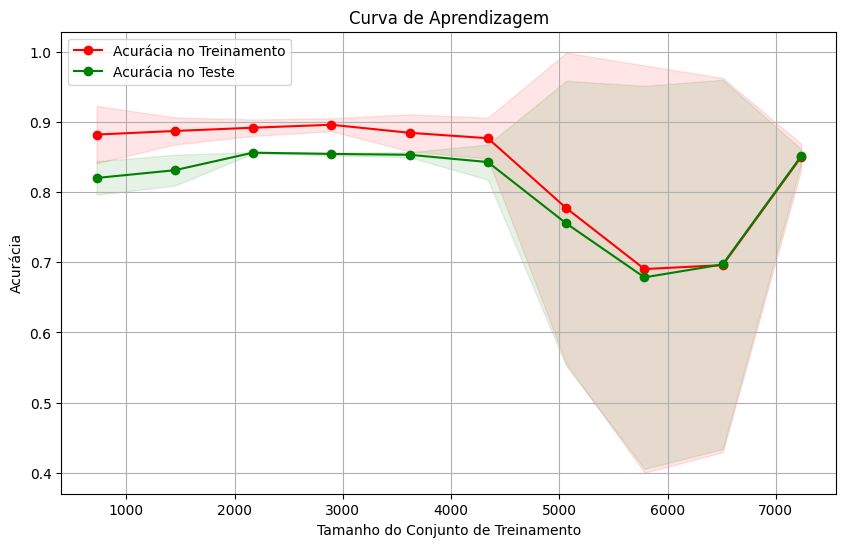

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Plotar gráficos
metrics = {
    'Acurácia': accuracy,
    'Precisão': precision,
    'Sensibilidade': recall,
    'Especificidade Média': mean_specificity
}

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['benign', 'malignant'])
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar os resultados
print("Acurácia:", accuracy)
print("Relatório de Classificação:\n", report)
print("Matriz de Confusão:\n", conf_matrix)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['benign', 'malignant'], rotation=45)
plt.yticks(tick_marks, ['benign', 'malignant'])
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.grid(False)

for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

# Plotar curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(mlp, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Acurácia no Treinamento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Acurácia no Teste")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title('Curva de Aprendizagem')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc="best")
plt.grid()
plt.show()